# Label author status
Label author status according to (1) prior comment count (\~ experience); (2) location; (3) prior comment length (\~ engagement).

In [1]:
# load comments
comment_data_dir = '../../data/nyt_comments/'
month_year_pairs = [
    ('Jan', '2017'), 
    ('Feb', '2017'),
    ('March', '2017'),
    ('April', '2017'),
    ('Jan', '2018'), 
    ('Feb', '2018'),
    ('March', '2018'),
    ('April', '2018'),
]
import os
import pandas as pd
comment_data = []
comment_data_cols = ['articleID', 'commentBody', 'commentID', 'commentType', 'createDate', 
                     'depth', 'parentID', 'recommendedFlag', 
                     'reportAbuseFlag', 'sectionName', 
                     'userID', 'userDisplayName', 'userLocation']
for month_i, year_i in month_year_pairs:
    comment_data_file_i = os.path.join(comment_data_dir, f'Comments{month_i}{year_i}.csv')
    comment_data_i = pd.read_csv(comment_data_file_i, sep=',', index_col=False, usecols=comment_data_cols)
    comment_data.append(comment_data_i)
comment_data = pd.concat(comment_data, axis=0)

<ipython-input-1-29bceb687512>:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  comment_data = pd.concat(comment_data, axis=0)


In [2]:
## add simplified date value
from datetime import datetime
def round_date_to_day(time_stamp):
    raw_date = datetime.fromtimestamp(time_stamp)
    round_date = datetime(year=raw_date.year, month=raw_date.month, day=raw_date.day)
    return round_date
comment_data = comment_data.assign(**{
    'date_day' : comment_data.loc[:, 'createDate'].apply(lambda x: round_date_to_day(x))
})
# print(datetime.fromtimestamp(comment_data.loc[:, 'createDate'].iloc[0]))
display(comment_data.head())

,articleID,commentBody,commentID,commentType,createDate,depth,parentID,recommendedFlag,reportAbuseFlag,sectionName,userDisplayName,userID,userLocation,date_day
0,58691a5795d0e039260788b9,For all you Americans out there --- still rejo...,20969730.0,comment,1.483426e+09,1.0,0.0,NaN,NaN,Politics,N. Smith,64679318.0,New York City,2017-01-03
1,58691a5795d0e039260788b9,Obamas policies may prove to be the least of t...,20969325.0,comment,1.483417e+09,1.0,0.0,NaN,NaN,Politics,Kilocharlie,69254188.0,Phoenix,2017-01-02
2,58691a5795d0e039260788b9,Democrats are comprised of malcontents who gen...,20969855.0,comment,1.483431e+09,1.0,0.0,NaN,NaN,Politics,Frank Fryer,76788711.0,Florida,2017-01-03
3,58691a5795d0e039260788b9,The picture in this article is the face of con...,20969407.0,comment,1.483419e+09,1.0,0.0,NaN,NaN,Politics,James Young,72718862.0,Seattle,2017-01-02
4,58691a5795d0e039260788b9,Elections have consequences.,20969274.0,comment,1.483417e+09,1.0,0.0,NaN,NaN,Politics,M.,7529267.0,Seattle,2017-01-02


In [3]:
def compute_prior_comment_count(full_data, date_var='date_day', author_var='userID'):
    """
    Compute prior number of comments/day per author.
    """
    comment_count_per_author = []
    for (author_i, date_i), data_i in full_data.groupby([author_var, date_var]):
        prior_data_i = full_data[(full_data.loc[:, 'userID']==author_i) & 
                                 (full_data.loc[:, date_var] <= date_i)]
        date_range_i = (prior_data_i.loc[:, date_var].max() - prior_data_i.loc[:, date_var].min()).days + 1 # "smooth" to avoid div-by-0
        comment_count_i = prior_data_i.shape[0] / date_range_i
        comment_count_per_author.append([author_i, date_i, comment_count_i])
    comment_count_per_author = pd.DataFrame(comment_count_per_author, columns=[author_var, date_var, 'prior_comment_count'])
    return comment_count_per_author
def compute_prior_comment_length(full_data, tokenizer, text_var='commentBody', date_var='date_day', author_var='userID'):
    """
    Compute prior length of comment per author.
    """
    comment_len_per_author = []
    # get tokens
    full_data = full_data.assign(**{
        'comment_tokens' : full_data.loc[:, 'commentBody'].apply(tokenizer.tokenize)
    })
    for (author_i, date_i), data_i in full_data.groupby([author_var, date_var]):
        prior_data_i = full_data[(full_data.loc[:, 'userID']==author_i) & 
                                 (full_data.loc[:, date_var] <= dacte_i)]
        comment_len_i = prior_data_i.loc[:, 'comment_tokens'].apply(lambda x: len(x))
        mean_comment_len_i = comment_len_i.mean()
        comment_len_per_author.append([author_i, date_i, mean_comment_len_i])
    comment_len_per_author = pd.DataFrame(comment_len_per_author, columns=[author_var, date_var, 'prior_comment_len'])
    return comment_len_per_author

In [4]:
# comment count
date_var = 'date_day'
author_var = 'userID'
comment_count_per_author = compute_prior_comment_count(comment_data, date_var=date_var, author_var=author_var)

In [5]:
# comment length
from nltk.tokenize import WordPunctTokenizer
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import clean_text_matchers
import re
# clean HTML`
text_var = 'commentBody'
matcher_pairs = [
    (re.compile('<.+>'), ' '), #HTML
]
word_tokenizer = WordPunctTokenizer()
comment_data = comment_data.assign(**{
    text_var : comment_data.loc[:, text_var].apply(lambda x: clean_text_matchers(x, word_tokenizer, matcher_pairs))
})
comment_len_per_author = compute_prior_comment_length(comment_data, word_tokenizer, 
                                                      text_var=text_var, date_var=date_var,
                                                      author_var=author_var)

In [ ]:
## save to file
author_var = 'userID'
round_date_var = 'date_day'
combined_comment_author_data = pd.merge(comment_count_per_author, comment_len_per_author, on=[author_var, round_date_var])
combined_comment_author_data_file = '../../data/nyt_comments/author_comment_stats.tsv'
combined_comment_author_data.to_csv(combined_comment_author_data_file, sep='\t', index=False)

In [41]:
import pandas as pd
combined_comment_author_data = pd.read_csv('../../data/nyt_comments/author_comment_stats.tsv', sep='\t', index_col=False)
# clean up date var
combined_comment_author_data = combined_comment_author_data[combined_comment_author_data.loc[:, 'date_day_x'] == combined_comment_author_data.loc[:, 'date_day_y']]
combined_comment_author_data = combined_comment_author_data.rename(columns={'date_day_x' : 'date_day'}).drop('date_day_y', axis=1)
# remove 0 values??
combined_comment_author_data = combined_comment_author_data[combined_comment_author_data.loc[:, 'prior_comment_len'] > 0]

In [44]:
# log-transform
import numpy as np
comment_vars = ['prior_comment_count', 'prior_comment_len']
for comment_var in comment_vars:
    combined_comment_author_data = combined_comment_author_data.assign(**{
        f'log_{comment_var}' : np.log(combined_comment_author_data.loc[:, comment_var])
    })

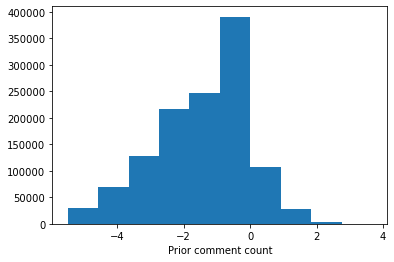

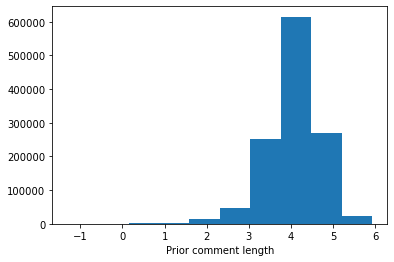

In [45]:
## display distribution of comment stats
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# comment count
plt.hist(combined_comment_author_data.loc[:, 'log_prior_comment_count'])
# plt.yscale('log')
plt.xlabel('Prior comment count')
plt.show()
# comment length
plt.hist(combined_comment_author_data.loc[:, 'log_prior_comment_len'])
# plt.yscale('log')
plt.xlabel('Prior comment length')
plt.show()

Let's do the easy thing: split the authors at the 50th percentile for both attributes.

In [46]:
import numpy as np
comment_cutoff_pct = 50
comment_cutoff_count = [np.percentile(combined_comment_author_data.loc[:, 'log_prior_comment_count'].values, comment_cutoff_pct)]
comment_cutoff_len = [np.percentile(combined_comment_author_data.loc[:, 'log_prior_comment_len'].values, comment_cutoff_pct)]
combined_comment_author_data = combined_comment_author_data.assign(**{
    'prior_comment_count_bin' : np.digitize(combined_comment_author_data.loc[:, 'log_prior_comment_count'], comment_cutoff_count),
    'prior_comment_len_bin' : np.digitize(combined_comment_author_data.loc[:, 'log_prior_comment_len'], comment_cutoff_len),
})
print(combined_comment_author_data.loc[:, 'prior_comment_count_bin'].value_counts())
print(combined_comment_author_data.loc[:, 'prior_comment_len_bin'].value_counts())

1    611600
0    611588
Name: prior_comment_count_bin, dtype: int64
1    611690
0    611498
Name: prior_comment_len_bin, dtype: int64


Now let's label authors by location: US vs. non-US.

In [3]:
## let's do some geocoding
import geocoder
def geocode_country(text):
    text_loc_country = 'UNK'
    try:
        text_loc = geocoder.osm(text, method='geocode')
        text_loc_data = text_loc.response.json()
        if(len(text_loc_data) > 0):
            text_loc_country = text_loc_data[0]['address']['country_code']
    except Exception as e:
        print(f'geocoding error {e}')
    return text_loc_country

author_locations = pd.Series(comment_data.loc[:, 'userLocation'].unique())
print(author_locations)
# DO NOT use parallel w/ too many workers => rate limit
from pandarallel import pandarallel
num_workers = 2
pandarallel.initialize(progress_bar=True, nb_workers=num_workers)
# from tqdm import tqdm
# tqdm.pandas()
author_location_countries = author_locations.parallel_apply(geocode_country)

0                    New York City
1                          Phoenix
2                          Florida
3                          Seattle
4                            NY NY
                   ...            
44465                  Henrico va.
44466                      á´œsá´€
44467                 Rocksylvania
44468    The Nation's File Cabinet
44469                Veracruz, Mex
Length: 44470, dtype: object
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5.0)


geocoding error 'NoneType' object has no attribute 'json'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'


Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5.0)


geocoding error 'NoneType' object has no attribute 'json'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error Coords are not within the world's geographical boundary
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'


Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5.0)


geocoding error 'NoneType' object has no attribute 'json'
geocoding error 'country_code'


Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5.0)


geocoding error 'NoneType' object has no attribute 'json'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error Coords are not within the world's geographical boundary
geocoding error 'country_code'
geocoding error 'country_code'
geocoding error 'country_code'


Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5.0)


geocoding error 'NoneType' object has no attribute 'json'


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



geocoding error 'country_code'


Status code Unknown from https://nominatim.openstreetmap.org/search: ERROR - HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5.0)


geocoding error 'NoneType' object has no attribute 'json'
geocoding error 'country_code'


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
pd.set_option('display.max_rows', 100)
author_location_data = pd.DataFrame([
    author_locations,
    author_location_countries,
], index=['userLocation', 'location_country']).transpose()
# fix common mistakes
top_k_locations = comment_data.loc[:, 'userLocation'].value_counts().head(100).index.tolist()
display(author_location_data[author_location_data.loc[:, 'userLocation'].isin(top_k_locations)])
gold_location_countries = {
    'New York City' : 'us',
    'NY NY' : 'us',
    'Earth' : 'UNK',
    '</br>' : 'UNK',
    'CA' : 'us',
    'PA' : 'us',
    'MA' : 'us',
    'Here' : 'UNK',
    'DC' : 'us',
}
author_location_data = author_location_data.assign(**{
    'location_country' : author_location_data.apply(
        lambda x: gold_location_countries[x.loc['userLocation']] if x.loc['userLocation'] in gold_location_countries else x.loc['location_country'], axis=1)
})
# add countries to data
if('location_country' not in comment_data.columns):
    comment_data = pd.merge(comment_data, author_location_data, on='userLocation')
display(comment_data.loc[:, 'location_country'].value_counts().head(20))

,userLocation,location_country
0,New York City,hn
1,Phoenix,us
2,Florida,us
3,Seattle,us
5,nyc,us
7,<br/>,br
10,NYC,us
13,NH,us
16,New York,us
17,Austin,us


us     1559652
UNK      67796
ca       54273
gb       29826
fr       19400
br       14826
au       12603
it        8766
co        8280
de        7848
mx        5507
cn        5297
in        4716
ph        4219
nl        4135
es        3826
se        3773
vn        3761
no        3645
ch        3158
Name: location_country, dtype: int64

OK! The distribution of countries looks reasonable, with most of the participation coming from English-speaking countries (UK, Canada, Australia).

Let's keep it simple for now and use US vs. non-US as the author label.

In [24]:
author_region_data = pd.DataFrame([
    ['us'],
    ['US'],
], index=['location_country', 'location_region']).transpose()
# add UNK countries
unk_countries = list(set(author_location_data.loc[:, 'location_country'].unique()) - set(['us']))
unk_region_data = pd.DataFrame([unk_countries, ['non_US',]*len(unk_countries)], index=['location_country', 'location_region']).transpose()
author_region_data = pd.concat([
    author_region_data,
    unk_region_data,
], axis=0)
display(author_region_data.head(20))
if('location_region' not in comment_data.columns):
    comment_data = pd.merge(comment_data, author_region_data, on='location_country')
print(comment_data.loc[:, 'location_region'].value_counts())

,location_country,location_region
0,us,US
0,ck,non_US
1,cz,non_US
2,py,non_US
3,lc,non_US
4,sz,non_US
5,cu,non_US
6,bz,non_US
7,my,non_US
8,ky,non_US


US        1559652
non_US     340323
Name: location_region, dtype: int64


Let's save all the author data to a combined file.

In [53]:
author_comment_region_data = comment_data.loc[:, ['userID', 'location_region']].drop_duplicates('userID')
author_comment_bin_data = combined_comment_author_data.loc[:, ['userID', 'date_day', 'prior_comment_count_bin', 'prior_comment_len_bin']]
author_social_data = pd.merge(author_comment_bin_data, author_comment_region_data, on='userID')
# fix author ID
author_social_data = author_social_data.assign(**{
    'userID' : author_social_data.loc[:, 'userID'].astype(int)
})
display(author_social_data.head())
author_social_data_file = '../../data/nyt_comments/author_comment_social_data.tsv'
author_social_data.to_csv(author_social_data_file, sep='\t', index=False)

,userID,date_day,prior_comment_count_bin,prior_comment_len_bin,location_region
0,1045,2017-04-09,1,0,US
1,1045,2018-01-17,0,0,US
2,1045,2018-01-24,0,0,US
3,1072,2017-03-13,1,1,US
4,1072,2018-01-03,0,1,US


### Test classification by author type

Before we use these features to blindly generate text, let's see how well we can classify the author status based on the comment text, i.e. weak version of authorship attribution.

We'll combine the representation of the article text and the comment text as a single input representation to predict the output (author "class").

In [ ]:
## convert continuous variables into binary categories
import numpy as np
comment_count_cutoff_pct = [25]
comment_len_cutoff_pct = [50]
combined_comment_author_data = pd.read_csv('../../data/nyt_comments/comment_author_stats.tsv', sep='\t', index_col=False)